In [1]:
import cv2
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## **1. LOAD AND PREPROCESS IMAGE**

In [2]:
# load dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
#preprocessing
x_train = X_train / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = X_test / 255.0
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [4]:
#create validation set from test set: 10% test set -> 1000
x_val = x_test[:1000]
y_val = y_test[:1000]
x_test = x_test[1000:]
y_test = y_test[1000:]

In [5]:
# X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

# fig, axis = plt.subplots(1, 4, figsize=(20, 10))
# for i, ax in enumerate(axis.flat):
#     ax.imshow(X_train__[i], cmap='binary')
#     digit = y_train[i].argmax()
#     ax.set(title=f"Real Number is {digit}");

## **2. CNN Model**

In [6]:
model = Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation="relu"))

model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

In [7]:
# With data augmentation to prevent overfitting
batch_size = 128

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.01,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# datagen.fit(X_train)
train_gen = datagen.flow(x_train, y_train, batch_size=batch_size)
valid_gen = datagen.flow(x_val, y_val, batch_size=batch_size)
test_gen = datagen.flow(x_test, y_test, batch_size=batch_size)

In [8]:
epochs = 100
train_steps = x_train.shape[0] // batch_size
valid_steps = x_val.shape[0] // batch_size

es = EarlyStopping(
    monitor="val_acc",  # metrics to monitor
    patience=10,  # how many epochs before stop
    verbose=1,
    mode="max",  # we need the maximum accuracy.
    restore_best_weights=True,  #
)

rp = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.2,
    patience=3,
    verbose=1,
    mode="max",
    min_lr=0.00001,
)

In [9]:
# Fit the model
history = model.fit(train_gen,
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = valid_gen,
                              validation_steps = valid_steps,
                             callbacks=[es, rp])

Epoch 1/100
468/468 [==============================] - 32s 45ms/step - loss: 0.1270 - accuracy: 0.9607 - val_loss: 0.6229 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 2/100
468/468 [==============================] - 20s 44ms/step - loss: 0.0525 - accuracy: 0.9842 - val_loss: 0.0737 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 3/100
468/468 [==============================] - 20s 44ms/step - loss: 0.0426 - accuracy: 0.9865 - val_loss: 0.0647 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 4/100
468/468 [==============================] - 21s 44ms/step - loss: 0.0386 - accuracy: 0.9883 - val_loss: 0.0462 - val_accuracy: 0.9866 - lr: 0.0010
Epoch 5/100
468/468 [==============================] - 20s 42ms/step - loss: 0.0336 - accuracy: 0.9897 - val_loss: 0.0220 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 6/100
468/468 [==============================] - 21s 44ms/step - loss: 0.0315 - accuracy: 0.9904 - val_loss: 0.0289 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 7/100
468/468 [==============================]

In [10]:
score_train = model.evaluate(x_train,y_train)
score_test = model.evaluate(x_test, y_test)
print('score-train: ',score_train)
print('score-test: ',score_test)
print('score-train using gen: ',model.evaluate(train_gen))
print('score-test using gen: ',model.evaluate(test_gen))

282/282 [==============================] - 1s 4ms/step - loss: 0.2249 - accuracy: 0.9940
score-train:  [0.0019836549181491137, 0.9992833137512207]
score-test:  [0.22485314309597015, 0.9940000176429749]
469/469 [==============================] - 19s 40ms/step - loss: 0.0028 - accuracy: 0.9991
score-train using gen:  [0.0027649039402604103, 0.9991166591644287]
71/71 [==============================] - 3s 41ms/step - loss: 0.0221 - accuracy: 0.9951
score-test using gen:  [0.022063028067350388, 0.9951111078262329]


In [11]:
y_pre = model.predict(x_test)

282/282 [==============================] - 1s 2ms/step


In [12]:
np.sum(np.argmax(y_pre,axis=1) == np.argmax(y_test,axis=1))/y_test.shape[0]

0.994

# **3. Evaluate the model**
## ***3.1 Training and validation curves***

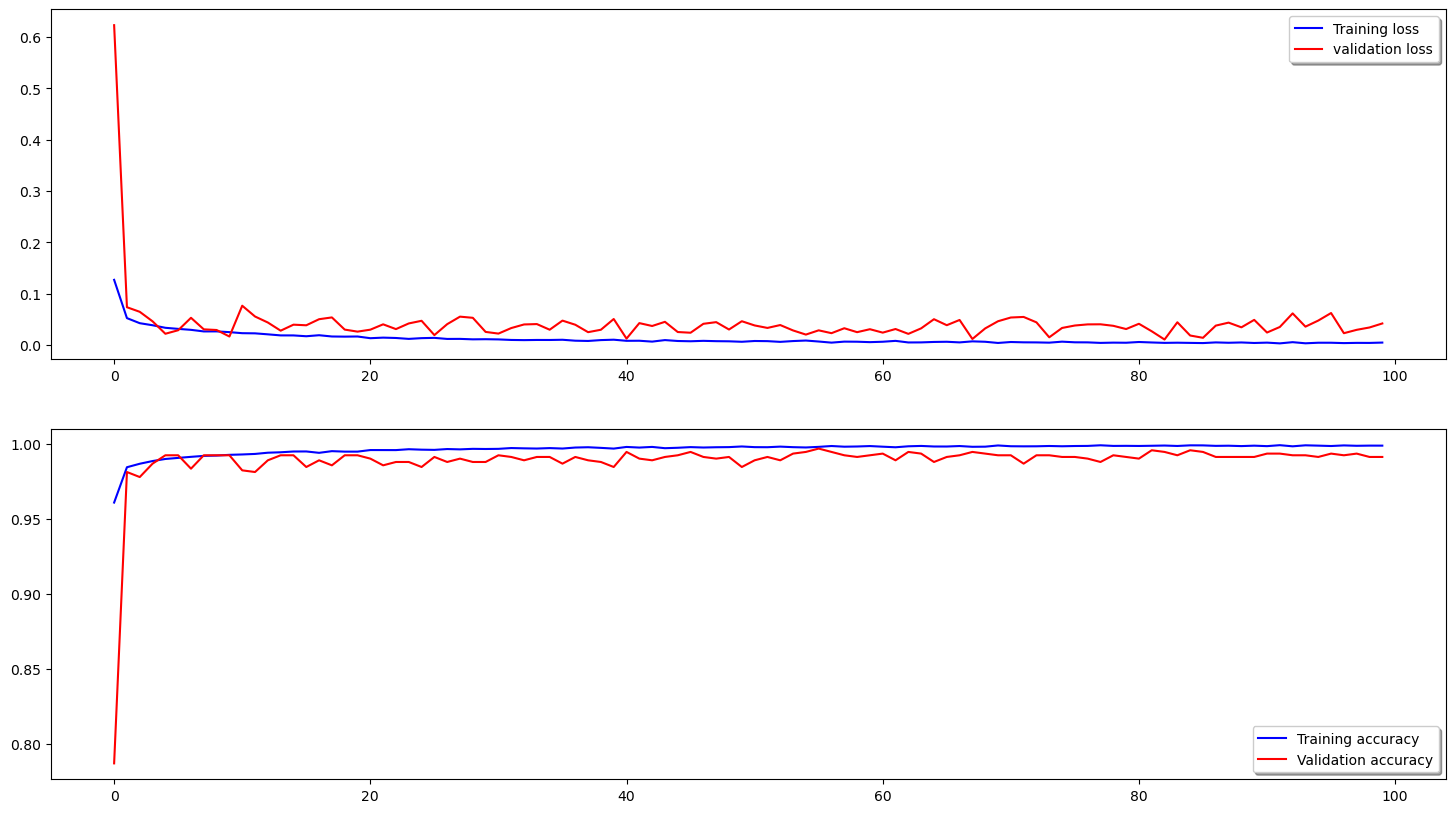

In [13]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## ***3.2 Confusion matrix***

282/282 [==============================] - 1s 2ms/step


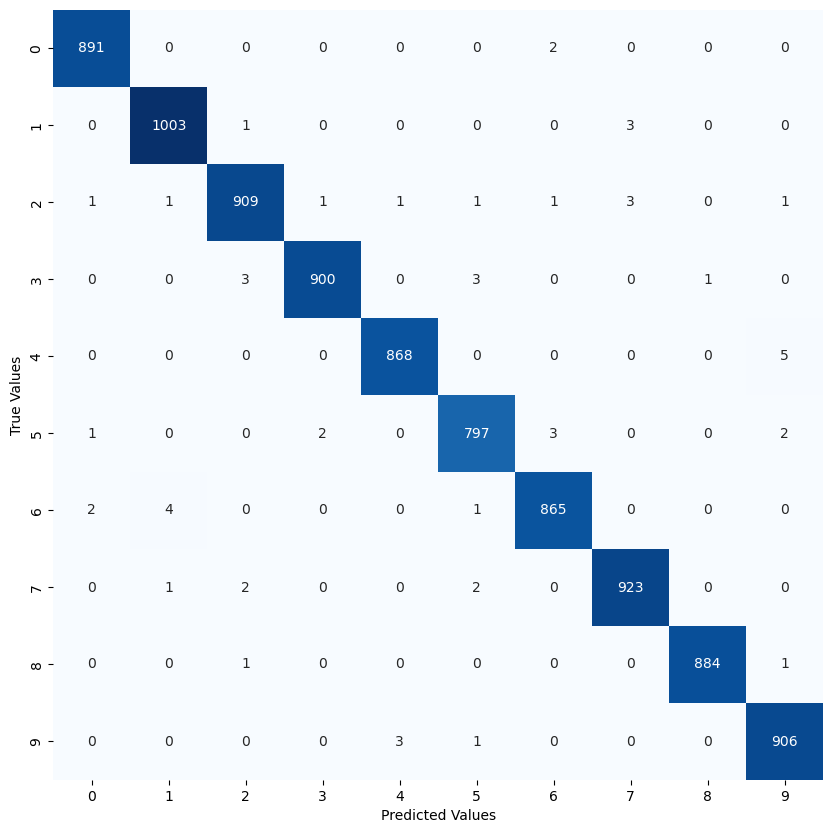

In [14]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(x_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

## **4. Prediction and submition**
## ***4.1 Prediction validation results***

282/282 [==============================] - 1s 2ms/step


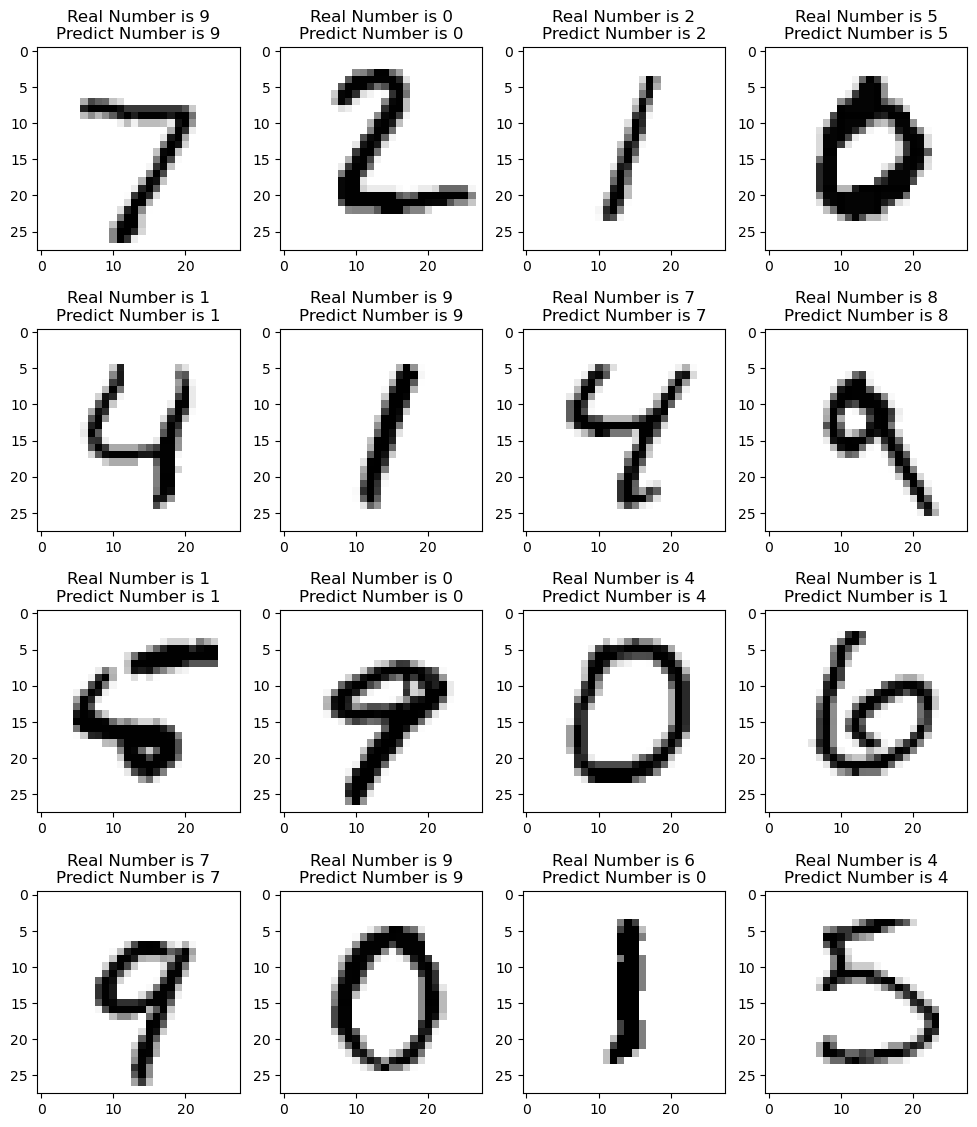

In [15]:
y_pred = model.predict(x_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

## ***4.2 Submition***

In [16]:
# Evaluate the model
score = model.evaluate(x_test,y_test)
print(score)

282/282 [==============================] - 1s 3ms/step - loss: 0.2249 - accuracy: 0.9940
[0.22485314309597015, 0.9940000176429749]


In [17]:
import pickle

# Lưu mô hình ở định dạng h5
model.save('cnn_mnist_v1.h5')

# Lưu mô hình ở định dạng hdf5
model.save_weights('cnn_mnist_v1.hdf5')

# Lưu mô hình ở định dạng pkl
pickle.dump(model, open('cnn_mnist_v1.pkl', 'wb'))
